## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
%matplotlib inline

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [6]:
def compFitModel(hw):
    results = {}
    for bs in BATCH_SIZE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with batch size = %s" % (bs))
        if (hw==1):   #作業 1
            model = build_mlp_1(input_shape=x_train.shape[1:])
        if (hw==2):   #作業 2
            model = build_mlp_2(input_shape=x_train.shape[1:])
        if (hw==3):   #作業 3
            model = build_mlp_3(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=bs, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "bs-%s" % str(bs)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}  
    return results

In [7]:
def showPicture(results):
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

## 作業 1 : 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

In [8]:
def build_mlp_1(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
results = compFitModel(hw=1)

Experiment with batch size = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)     

50000/50000 [==============================] - 182s 4ms/step - loss: 2.2412 - acc: 0.1638 - val_loss: 2.9212 - val_acc: 0.1836
Epoch 50/50
50000/50000 [==============================] - 182s 4ms/step - loss: 2.2422 - acc: 0.1630 - val_loss: 2.8180 - val_acc: 0.1808
Experiment with batch size = 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)  

50000/50000 [==============================] - 23s 468us/step - loss: 1.1275 - acc: 0.6012 - val_loss: 1.3783 - val_acc: 0.5224
Epoch 48/50
50000/50000 [==============================] - 24s 478us/step - loss: 1.1255 - acc: 0.6002 - val_loss: 1.3176 - val_acc: 0.5386
Epoch 49/50
50000/50000 [==============================] - 24s 483us/step - loss: 1.1247 - acc: 0.5997 - val_loss: 1.3493 - val_acc: 0.5238
Epoch 50/50
50000/50000 [==============================] - 25s 498us/step - loss: 1.1137 - acc: 0.6051 - val_loss: 1.4193 - val_acc: 0.5045
Experiment with batch size = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (B

50000/50000 [==============================] - 13s 251us/step - loss: 0.8393 - acc: 0.6997 - val_loss: 1.5372 - val_acc: 0.5034
Epoch 46/50
50000/50000 [==============================] - 13s 262us/step - loss: 0.8293 - acc: 0.7048 - val_loss: 1.5720 - val_acc: 0.5018
Epoch 47/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.8125 - acc: 0.7109 - val_loss: 1.5089 - val_acc: 0.5252
Epoch 48/50
50000/50000 [==============================] - 13s 256us/step - loss: 0.8111 - acc: 0.7096 - val_loss: 1.5583 - val_acc: 0.5024
Epoch 49/50
50000/50000 [==============================] - 13s 255us/step - loss: 0.8068 - acc: 0.7093 - val_loss: 1.5061 - val_acc: 0.5231
Epoch 50/50
50000/50000 [==============================] - 12s 249us/step - loss: 0.7923 - acc: 0.7173 - val_loss: 1.5799 - val_acc: 0.5026
Experiment with batch size = 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1

50000/50000 [==============================] - 5s 96us/step - loss: 0.3416 - acc: 0.8817 - val_loss: 2.3963 - val_acc: 0.4546
Epoch 44/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3362 - acc: 0.8835 - val_loss: 2.3043 - val_acc: 0.4724
Epoch 45/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.3406 - acc: 0.8800 - val_loss: 2.3513 - val_acc: 0.4681
Epoch 46/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.3233 - acc: 0.8885 - val_loss: 2.4386 - val_acc: 0.4749
Epoch 47/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.3074 - acc: 0.8954 - val_loss: 2.5494 - val_acc: 0.4574
Epoch 48/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.3018 - acc: 0.8955 - val_loss: 2.4718 - val_acc: 0.4453
Epoch 49/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.2952 - acc: 0.8968 - val_loss: 2.5249 - val_acc: 0.4582
Epoch 50/50
50000/50000 [=====================

Epoch 42/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.2521 - acc: 0.9267 - val_loss: 2.2612 - val_acc: 0.4703
Epoch 43/50
50000/50000 [==============================] - 4s 70us/step - loss: 0.2410 - acc: 0.9291 - val_loss: 2.4408 - val_acc: 0.4642
Epoch 44/50
50000/50000 [==============================] - 3s 70us/step - loss: 0.2340 - acc: 0.9316 - val_loss: 2.3887 - val_acc: 0.4634
Epoch 45/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.2138 - acc: 0.9399 - val_loss: 2.3730 - val_acc: 0.4597
Epoch 46/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.2144 - acc: 0.9381 - val_loss: 2.3180 - val_acc: 0.4797
Epoch 47/50
50000/50000 [==============================] - 4s 72us/step - loss: 0.1943 - acc: 0.9465 - val_loss: 2.3989 - val_acc: 0.4760
Epoch 48/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.1780 - acc: 0.9527 - val_loss: 2.4085 - val_acc: 0.4743
Epoch 49/50
50000/50000 [=========

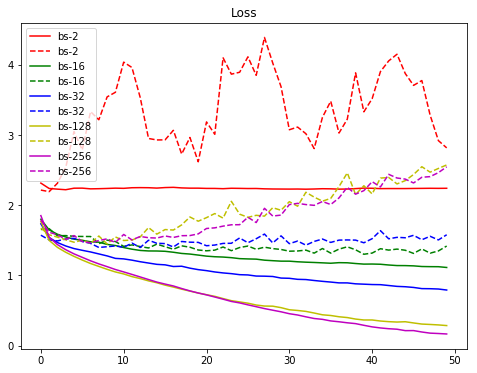

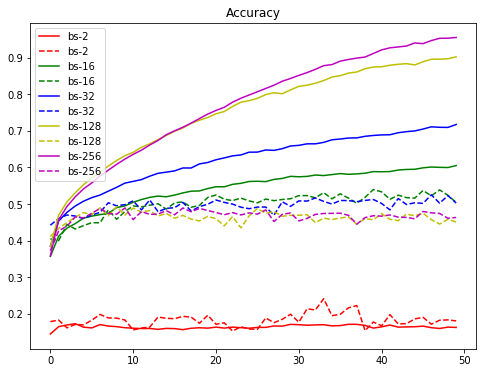

In [10]:
showPicture(results) 

## 作業 2 : 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [13]:
BATCH_SIZE = [256]
def build_mlp_2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
results = compFitModel(hw=2)

Experiment with batch size = 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)    

50000/50000 [==============================] - 3s 67us/step - loss: 0.1923 - acc: 0.9501 - val_loss: 2.2284 - val_acc: 0.4855


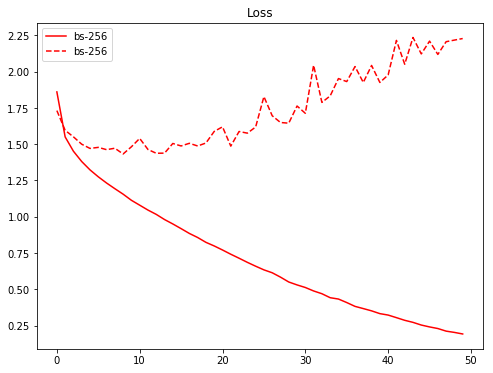

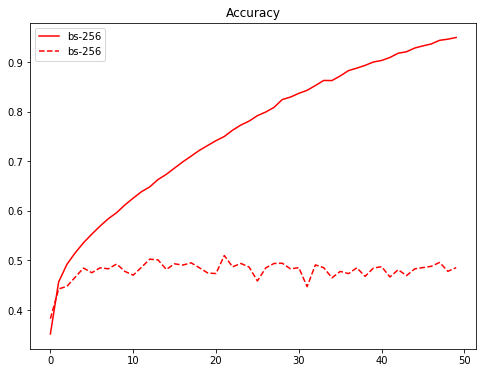

In [15]:
showPicture(results) 

## 作業 3 : 請於 BN 放在 Input Layer 後，並比較結果

In [16]:
BATCH_SIZE = [256]
def build_mlp_3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
results = compFitModel(hw=3)

Experiment with batch size = 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)    

50000/50000 [==============================] - 3s 66us/step - loss: 0.4557 - acc: 0.8478 - val_loss: 1.9137 - val_acc: 0.4841


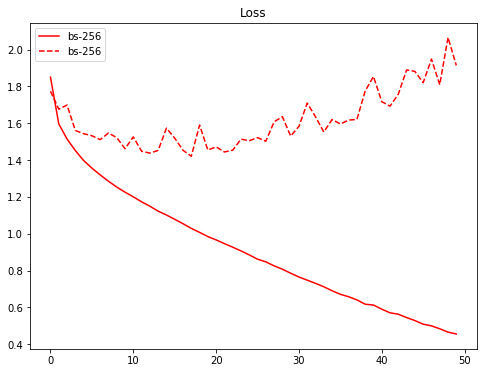

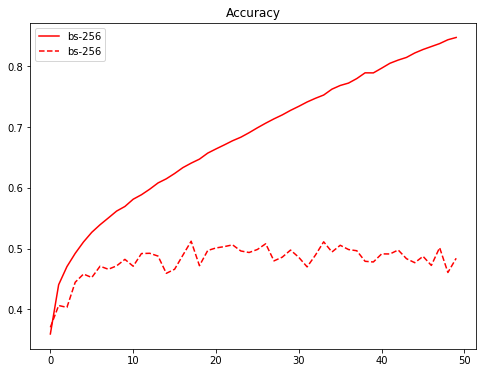

In [18]:
showPicture(results) 

# 結論 1 : <font color='red'>BATCH_SIZE 愈大, compile 速度愈快</font>